# First study case scenario
In this scenario we will teach model on the dataset containing traffic belonging only to normal users, and then we will try to check if it can detect malicious traffic

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM


In [4]:
files = ["Monday-WorkingHours.pcap_ISCX.csv", #0
         "Tuesday-WorkingHours.pcap_ISCX.csv", #1
         "Wednesday-workingHours.pcap_ISCX.csv", #2
         "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv", #3
         "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv", #4
         "Friday-WorkingHours-Morning.pcap_ISCX.csv", #5
         "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", #6
         "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"] #7

def dataset_file_to_df(index: int, dataset_files: list):
    read_file = f"datasets/CSVs/{dataset_files[index]}"

    with open(read_file, "r") as f:
        lines = f.readlines()

    lines[0] = lines[0].replace(", ", ",")

    with open(read_file, "w") as f:
        f.writelines(lines)

    df_read = pd.read_csv(read_file)
    pattern = r'[^\w\s]'
    df_read['Label'] = df_read['Label'].replace(pattern, '', regex=True)
    df_read.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

    return df_read


df_mal = dataset_file_to_df(3, files)


In [5]:
def normalize(df):
    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
    df_norm = df.copy()
    for col in numeric_columns:
        if df[col].skew() > 0 or col == "Src Port":
            df_norm[col] = np.log1p(df[col].clip(lower=-0.99))  # Ensures log1p always gets valid input
        elif df[col].skew() < 0:
            df_norm[col] = df[col] ** 2  # Can cause overflow
    return df_norm

df_mal_normalized = normalize(df_mal)

In [6]:

X_norm = df_mal_normalized.query("Label == 'BENIGN'").drop(["Label", "Flow ID", "Src IP", "Timestamp", "Dst IP"], axis=1)
X_train, X_test = train_test_split(X_norm, test_size=0.3, random_state=42)

X_outl = df_mal_normalized.query("Label != 'BENIGN'").drop(["Label", "Flow ID", "Src IP", "Timestamp", "Dst IP"], axis=1)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_outl = scaler.transform(X_outl)


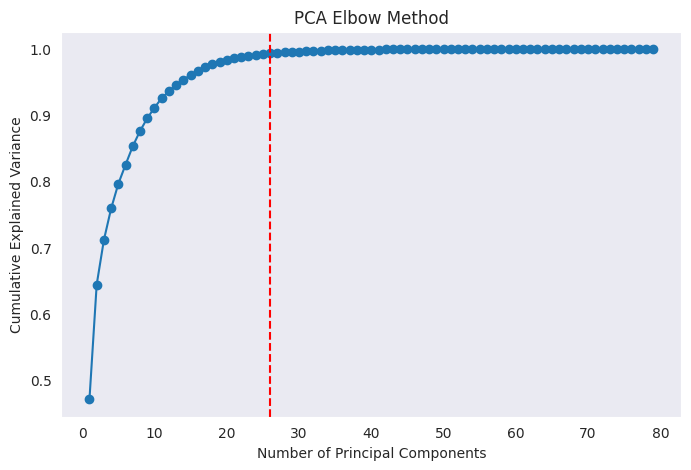

Optimal number of components: 26


In [7]:
pca = PCA()

pca.fit(X_train)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')

# Find the elbow point (where variance gain is <1%)
elbow_point = np.argmax(np.diff(cumulative_variance) < 0.001) + 1

plt.axvline(x=elbow_point, color='r', linestyle="--")  # Mark elbow
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Elbow Method")
plt.grid()
plt.show()

print(f"Optimal number of components: {elbow_point}")

In [8]:
pca = PCA(n_components=elbow_point)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_outl_pca = pca.transform(X_outl)

In [9]:
from itertools import product
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score
import numpy as np

class OneClassSVMGridSearch:
    def __init__(self, param_grid):
        """
        param_grid: Słownik list wartości hiperparametrów do testowania
        scoring: Funkcja oceniająca skuteczność modelu (np. accuracy_score)
        """
        self.param_grid = param_grid
        self.best_params_ = None
        self.best_score_ = -np.inf

    def fit(self, X_train, X_norm, X_outl):
        """
        Przeprowadza GridSearch po hiperparametrach OneClassSVM.

        X_train: Dane do treningu
        X_norm: Dane, które powinny zostać oznaczone jako "normal" (1)
        X_outl: Dane, które powinny zostać oznaczone jako "outlier" (-1)
        """
        param_names = list(self.param_grid.keys())
        param_values = list(self.param_grid.values())

        for param_comb in product(*param_values):
            params = dict(zip(param_names, param_comb))

            # Tworzymy i trenujemy model
            model = OneClassSVM(**params)
            model.fit(X_train)

            # Predykcja
            y_pred_norm = model.predict(X_norm)  # Powinny być wszystkie 1
            y_pred_outl = model.predict(X_outl)  # Powinny być wszystkie -1

            # Ocena
            score = len(y_pred_norm[y_pred_norm == 1]) / len(y_pred_norm) + (len(y_pred_outl[y_pred_outl == -1]) / len(y_pred_outl))

            # Aktualizacja najlepszego wyniku
            if score > self.best_score_:

                self.best_score_ = score
                self.best_params_ = params

        return self

param_grid = {
    "nu": [0.01, 0.1, 0.5],
    "kernel": ["rbf"],
    "gamma": ["scale", 0.1, 1, 0.01]
}

# Uruchomienie GridSearch dla OneClassSVM
search = OneClassSVMGridSearch(param_grid)
search.fit(X_train_pca, X_test_pca, X_outl_pca)

print("Najlepsze parametry:", search.best_params_)
print("Najlepszy wynik:", search.best_score_)


Starting new fit
Combination of:
{'nu': 0.01, 'kernel': 'rbf', 'gamma': 'scale'}
Starting new fit
Combination of:
{'nu': 0.01, 'kernel': 'rbf', 'gamma': 0.1}
Starting new fit
Combination of:
{'nu': 0.01, 'kernel': 'rbf', 'gamma': 1}
Starting new fit
Combination of:
{'nu': 0.01, 'kernel': 'rbf', 'gamma': 0.01}
Starting new fit
Combination of:
{'nu': 0.1, 'kernel': 'rbf', 'gamma': 'scale'}
Starting new fit
Combination of:
{'nu': 0.1, 'kernel': 'rbf', 'gamma': 0.1}
Starting new fit
Combination of:
{'nu': 0.1, 'kernel': 'rbf', 'gamma': 1}
Starting new fit
Combination of:
{'nu': 0.1, 'kernel': 'rbf', 'gamma': 0.01}
Starting new fit
Combination of:
{'nu': 0.5, 'kernel': 'rbf', 'gamma': 'scale'}
Starting new fit
Combination of:
{'nu': 0.5, 'kernel': 'rbf', 'gamma': 0.1}
Starting new fit
Combination of:
{'nu': 0.5, 'kernel': 'rbf', 'gamma': 1}
Starting new fit
Combination of:
{'nu': 0.5, 'kernel': 'rbf', 'gamma': 0.01}
Najlepsze parametry: {'nu': 0.01, 'kernel': 'rbf', 'gamma': 1}
Najlepszy wy

In [10]:
one_svm = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

one_svm.fit(X_train_pca)

y_pred_norm = one_svm.predict(X_test_pca)

y_pred_outl = one_svm.predict(X_outl_pca)

In [11]:
print(len(y_pred_norm[y_pred_norm == 1]) / len(y_pred_norm))
print(len(y_pred_outl[y_pred_outl == -1]) / len(y_pred_outl))

0.8996155065799905
0.9151376146788991


### Test on data without pca step - more information

In [12]:
from sklearn.svm import OneClassSVM

one_svm = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

one_svm.fit(X_train)

y_pred_norm = one_svm.predict(X_test)

y_pred_outl = one_svm.predict(X_outl)

In [13]:
print(len(y_pred_norm[y_pred_norm == 1]) / len(y_pred_norm))
print(len(y_pred_outl[y_pred_outl == -1]) / len(y_pred_outl))

0.9001308070397971
0.9059633027522935


In [13]:
import pickle

with open('../app/ml_model/oneclass-svm.pkl', 'wb') as file:
    pickle.dump(one_svm, file)